In [1]:
import pandas as pd
import seaborn as sns
sns.set()
import numpy as np
import matplotlib.pyplot as plt
import neurokit2 as nk
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

import os 
import shutil
from pathlib import Path


## to doublecheck with TA:
1. In the dataset participant ids of cohort 2 were numbered from 1 as well so it appears as the same people took part in the experiment, although the description implies that there were 28 disctinct participants...
2. Missing answers in questionnaire
3. Sometimes there is a "puzzler" 0/1 column, sometimes there is a "parent" 0/1 column. Is it correct that the role is "puzzler" if the "puzzler" column says 1 OR the "parent" column says zero and vice versa?

# Metadata

In [2]:


create_new_dataset = False

old_dataset_path = Path("dataset_orig")
new_dataset_path = Path("dataset")

if create_new_dataset:
    os.mkdir(new_dataset_path)
    for cohort in ["D1_1", "D1_2", "D1_3"]:
        os.mkdir(new_dataset_path / cohort)
    for subcohort in ["D1_3/D1_3_1", "D1_3/D1_3_2", "D1_3/D1_3_3", "D1_3/D1_3_4"]:
        os.mkdir(new_dataset_path / subcohort)
    
    
metadata = []

stats = ["BVP", "HR", "EDA", "TEMP"]
    
cohorts = ["D1_1", "D1_2", "D1_3/D1_3_1", "D1_3/D1_3_2", "D1_3/D1_3_3", "D1_3/D1_3_4"]
for cohort in cohorts:
    trial_ids = os.listdir(old_dataset_path / cohort)
    for trial_id in trial_ids:
        if create_new_dataset:
            os.mkdir(new_dataset_path / cohort / trial_id)
        for i in range(1, 5): # rounds
            if create_new_dataset:
                os.mkdir(new_dataset_path / cohort/ trial_id / f"round_{i}")
            for j in range(1, 4): # phases
                path = old_dataset_path / cohort / trial_id / f"round_{i}" / f"phase{j}"
                if create_new_dataset:
                    os.mkdir(new_dataset_path / cohort / trial_id / f"round_{i}" / f"phase{j}")
                response_path = path / "response.csv"
                response = pd.read_csv(response_path)
                response = response.drop(columns = ["Unnamed: 0"])
                
                # column names tend to be misspelled, let's correct that
                response = response.rename(columns = {"particpant_ID":"participant_ID"})
                
                # participant ids from the second cohort are off by 8
                if cohort == "D1_2":
                    response['participant_ID'] = response['participant_ID'] + 8
                    
                # let's save the corrected response to a new directory
                if create_new_dataset:
                    response.to_csv(new_dataset_path / cohort / trial_id / f"round_{i}" / f"phase{j}" / "response.csv")
                
                if j != 2:
                    response['difficulty'] = np.nan
                
                # they signify role with either "parent" or "puzzler" column... why didn't they choose one?
                if "parent" in response.columns and "puzzler" in response.columns:
                    print("both parent and puzzler id")
                elif "parent" in response.columns:
                    role = "parent" if response['parent'][0] == 1 else "puzzler"
                elif "puzzler" in response.columns:
                    role = "puzzler" if response['puzzler'][0] == 1 else "parent"
                else:
                    print("no parent id")
                    
                # about the timeseries data
                biostats = []
                for stat in stats:
                    
                    signal_path = path / f"{stat}.csv"
                    
                    # and all the other files should be copied over
                    if create_new_dataset:
                        shutil.copyfile(signal_path, new_dataset_path / cohort / trial_id / f"round_{i}" / f"phase{j}" / f"{stat}.csv")
                    
                    signal = pd.read_csv(signal_path, parse_dates = ['time']).drop(columns = ["Unnamed: 0"])
                    duration = signal['time'].max() - signal['time'].min()
                    samples = len(signal)
                    #nans = signal[stat].isna().sum() # actually there are no nans :)
                    biostats += [duration, samples]
                    
                row = [str(path), cohort, trial_id, f"round_{i}", f"phase{j}", role] + response.iloc[0].tolist() + biostats
                metadata.append(row)
                
metadata_cols = ["Path", "Cohort", "Trial", "Round", "Phase", "Role", # stuff about the datastructure
                 'participant_ID', 'parent/puzzler', 'team_ID', 'E4_nr', # ids
                 'upset', 'hostile', 'alert', 'ashamed', 'inspired', 'nervous', 'determined', 'attentive', 'afraid', 'active', # questionnaire 1-5
                 'frustrated', 'difficulty', # questionnaire 1-10
                ] + [f"{stat}_{s}" for stat in stats for s in ['duration', 'n']]

metadata = pd.DataFrame(metadata, columns=metadata_cols)
metadata.to_csv("metadata.csv", index=False)
metadata

,Path,Cohort,Trial,Round,Phase,Role,participant_ID,parent/puzzler,team_ID,E4_nr,...,frustrated,difficulty,BVP_duration,BVP_n,HR_duration,HR_n,EDA_duration,EDA_n,TEMP_duration,TEMP_n
0,dataset_orig/D1_1/ID_3/round_1/phase1,D1_1,ID_3,round_1,phase1,parent,1.0,0.0,1.0,A03701,...,5.0,NaN,0 days 00:07:22.265625,28306,0 days 00:07:21,442,0 days 00:07:22,1769,0 days 00:07:22,1769
1,dataset_orig/D1_1/ID_3/round_1/phase2,D1_1,ID_3,round_1,phase2,parent,1.0,0.0,1.0,A03701,...,3.0,2.0,0 days 00:05:45.484375,22112,0 days 00:05:44,345,0 days 00:05:45.250000,1382,0 days 00:05:45.250000,1382
2,dataset_orig/D1_1/ID_3/round_1/phase3,D1_1,ID_3,round_1,phase3,parent,1.0,0.0,1.0,A03701,...,1.0,NaN,0 days 00:06:09.078125,23622,0 days 00:06:08,369,0 days 00:06:08.750000,1476,0 days 00:06:08.750000,1476
3,dataset_orig/D1_1/ID_3/round_2/phase1,D1_1,ID_3,round_2,phase1,parent,1.0,0.0,1.0,A03701,...,4.0,NaN,0 days 00:05:04.765625,19506,0 days 00:05:04,305,0 days 00:05:04.500000,1219,0 days 00:05:04.500000,1219
4,dataset_orig/D1_1/ID_3/round_2/phase2,D1_1,ID_3,round_2,phase2,parent,1.0,0.0,1.0,A03701,...,4.0,7.0,0 days 00:07:04.781250,27187,0 days 00:07:03,424,0 days 00:07:04.500000,1699,0 days 00:07:04.500000,1699
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307,dataset_orig/D1_3/D1_3_4/ID_1/round_3/phase2,D1_3/D1_3_4,ID_1,round_3,phase2,parent,26.0,1.0,13.0,A03469,...,4.0,5.0,0 days 00:05:08.531250,19747,0 days 00:05:07,308,0 days 00:05:08.250000,1234,0 days 00:05:08.250000,1234
308,dataset_orig/D1_3/D1_3_4/ID_1/round_3/phase3,D1_3/D1_3_4,ID_1,round_3,phase3,parent,26.0,1.0,13.0,A03469,...,0.0,NaN,0 days 00:05:07.875000,19705,0 days 00:05:07,308,0 days 00:05:07.500000,1231,0 days 00:05:07.500000,1231
309,dataset_orig/D1_3/D1_3_4/ID_1/round_4/phase1,D1_3/D1_3_4,ID_1,round_4,phase1,parent,26.0,1.0,13.0,A03469,...,0.0,NaN,0 days 00:05:06.015625,19586,0 days 00:05:05,306,0 days 00:05:05.750000,1224,0 days 00:05:05.750000,1224
310,dataset_orig/D1_3/D1_3_4/ID_1/round_4/phase2,D1_3/D1_3_4,ID_1,round_4,phase2,parent,26.0,1.0,13.0,A03469,...,4.0,6.0,0 days 00:05:09.984375,19840,0 days 00:05:09,310,0 days 00:05:09.750000,1240,0 days 00:05:09.750000,1240


In [3]:

metadata[["team_ID", "participant_ID", "Cohort", "Trial", "Role", "parent/puzzler"]].groupby(["Cohort", "team_ID", "participant_ID"]).nunique() 

Trial  Role  parent/puzzler
Cohort      team_ID participant_ID                             
D1_1        1.0     1.0                 1     1               1
                    2.0                 1     1               1
            2.0     7.0                 1     1               1
                    8.0                 1     1               1
            3.0     3.0                 1     1               1
                    4.0                 1     1               1
            4.0     5.0                 1     1               1
                    6.0                 1     1               1
D1_2        1.0     9.0                 1     1               1
                    10.0                1     1               1
            2.0     11.0                1     1               1
                    12.0                1     1               1
            3.0     13.0                1     1               1
                    14.0                1     1               1
D1_3/D1_3_1 8.0     15.0                1     1               1
                    16.0                1     1               1
            9.0     17.0                1     1               1
                    18.0                1     1               1
D1_3/D1_3_2 10.0    19.0                1     1               1
                    20.0                1     1               1
            11.0    21.0                1     1               1
                    22.0                1     1               1
D1_3/D1_3_3 12.0    23.0                1     1               1
                    24.0                1     1               1
D1_3/D1_3_4 13.0    25.0                1     1               1
                    26.0                1     1               1

In [4]:
# devices were shared across cohorts
for i, group in metadata.groupby('Cohort'):
    print(i)
    print(sorted(group['E4_nr'].unique()))
    print()

D1_1
['A02B10', 'A02FBE', 'A0306B', 'A03072', 'A03701', 'A03804', 'A03857', 'A0388C']

D1_2
['A02857', 'A02B10', 'A02FBE', 'A02FC2', 'A02FD7', 'A03469']

D1_3/D1_3_1
['A0306B', 'A03469', 'A03701', 'A03857']

D1_3/D1_3_2
['A0306B', 'A03469', 'A03701', 'A03857']

D1_3/D1_3_3
['A0306B', 'A03701']

D1_3/D1_3_4
['A03469', 'A03857']



In [5]:
# fixed participant ids
for i, group in metadata.groupby('Cohort'):
    print(i)
    print(sorted(group['participant_ID'].unique()))
    print()

D1_1
[1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0]

D1_2
[9.0, 10.0, 11.0, 12.0, 13.0, 14.0]

D1_3/D1_3_1
[15.0, 16.0, 17.0, 18.0]

D1_3/D1_3_2
[19.0, 20.0, 21.0, 22.0]

D1_3/D1_3_3
[23.0, 24.0]

D1_3/D1_3_4
[25.0, 26.0]



# Basic features

BVP
19392
0 days 00:05:02.984375
HR
303
0 days 00:05:02
EDA
1212
0 days 00:05:02.750000
TEMP
1212
0 days 00:05:02.750000


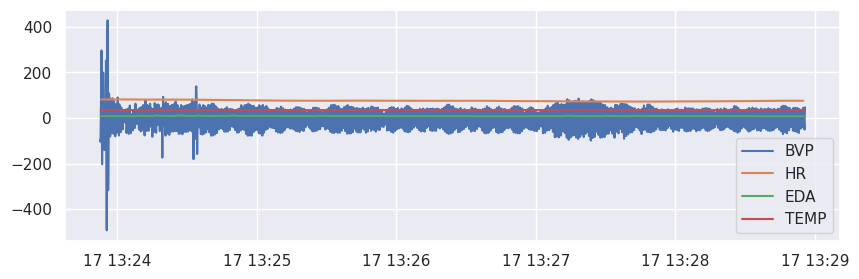

In [6]:
plt.figure(figsize=(10, 3))
for stat in ["BVP", "HR", "EDA", "TEMP"]:
    print(stat)
    df = pd.read_csv(f"dataset/D1_2/ID_1/round_1/phase1/{stat}.csv", parse_dates=['time']).rename(columns={'Unnamed: 0': 'id'})
    plt.plot(df['time'], df[stat], label=stat)
    plt.legend()
    print(len(df))
    print(df['time'].max()-df['time'].min())
    #print(df['time'].max())

In [7]:
def get_basic_features(path):
    features, feature_names = [], []
    for stat in ["BVP", "HR", "EDA", "TEMP"]:
        signal = pd.read_csv(f"{path}/{stat}.csv")[stat]
        features += [signal.min(), signal.max(), signal.mean(), signal.std()]
        feature_names += [f"{stat}_{f}" for f in ["min", "max", "mean", "std"]]
    return feature_names, features

get_basic_features("dataset/D1_1/ID_1/round_1/phase1")


(['BVP_min',
  'BVP_max',
  'BVP_mean',
  'BVP_std',
  'HR_min',
  'HR_max',
  'HR_mean',
  'HR_std',
  'EDA_min',
  'EDA_max',
  'EDA_mean',
  'EDA_std',
  'TEMP_min',
  'TEMP_max',
  'TEMP_mean',
  'TEMP_std'],
 [-962.52,
  923.56,
  -0.12582692845164895,
  47.95425262783292,
  75.13,
  85.12,
  78.49229910714287,
  2.146661906799045,
  0.175574,
  0.301167,
  0.24728642146450533,
  0.03621259965913564,
  30.97,
  31.47,
  31.2978814980436,
  0.08454004676175512])

In [8]:
%%time
basic_ds = []
for path in metadata['Path']:
    feature_names, features = get_basic_features(path)
    basic_ds.append(features)
    
basic_ds = pd.DataFrame(basic_ds, columns = feature_names)

CPU times: user 3.92 s, sys: 531 ms, total: 4.46 s
Wall time: 4.46 s


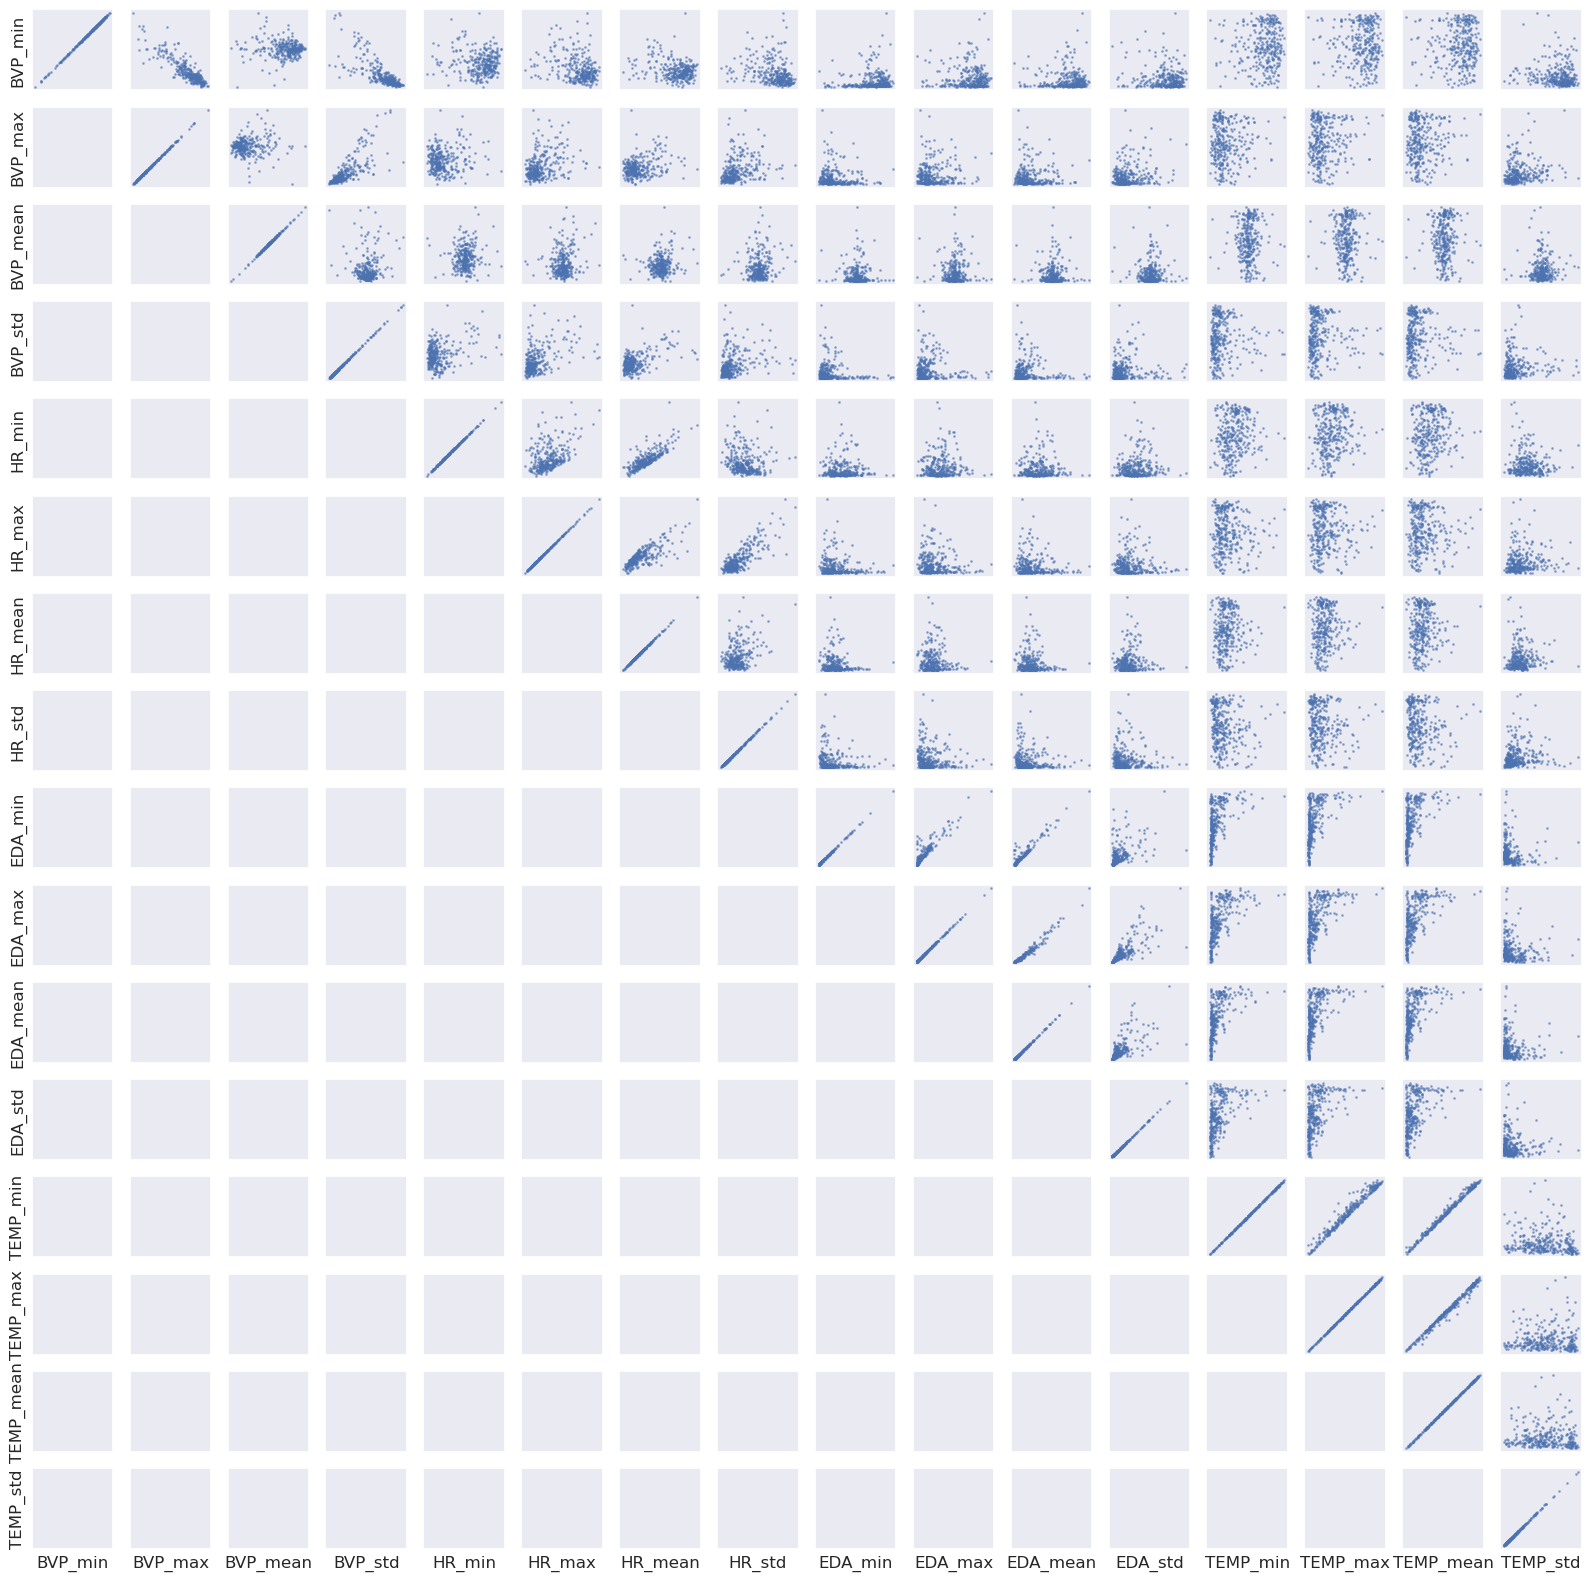

CPU times: user 6.24 s, sys: 79.3 ms, total: 6.32 s
Wall time: 6.33 s


In [9]:
%%time
fig, axs = plt.subplots(len(basic_ds.columns), len(basic_ds.columns), figsize=(20, 20))
for i, f1 in enumerate(basic_ds.columns):
    for j, f2 in enumerate(basic_ds.columns):
        if i <= j:
            axs[i][j].scatter(basic_ds[f1], basic_ds[f2], s=1, alpha=0.5)
        axs[i][j].set_xticks([])
        axs[i][j].set_yticks([])
        
        if j == 0:
            axs[i][j].set_ylabel(f1)
        if i == len(basic_ds.columns)-1:
            axs[i][j].set_xlabel(f2)
plt.show()

In [10]:


X = StandardScaler().fit_transform(basic_ds)
pca = PCA(n_components=2)
components = pca.fit_transform(X)
pca.explained_variance_ratio_

array([0.3189434 , 0.23164834])

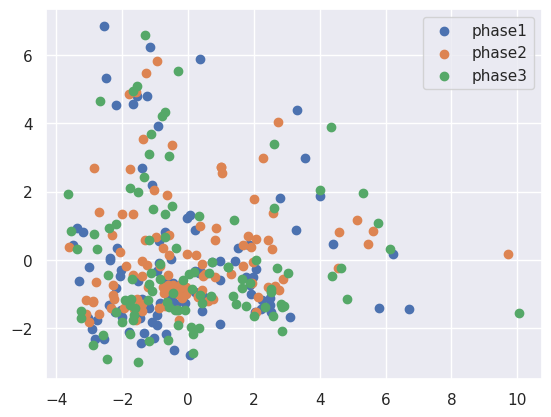

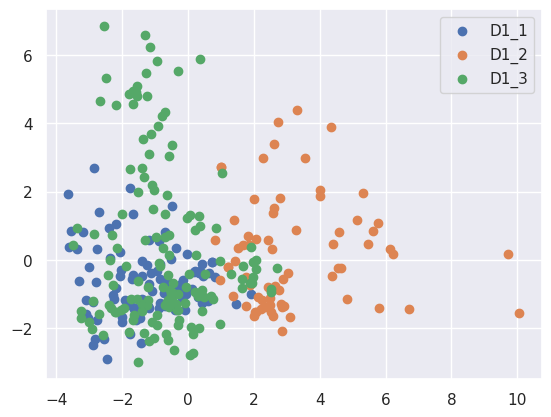

In [11]:
plt.figure()
for phase in ["phase1", "phase2", "phase3"]:
    idxs = metadata["Phase"] == phase
    plt.scatter(components[idxs, 0], components[idxs, 1], label=phase)
    
plt.legend()
plt.show()

plt.figure()
for cohort in ["D1_1", "D1_2", "D1_3"]:
    idxs = metadata["Cohort"].str.startswith(cohort)
    plt.scatter(components[idxs, 0], components[idxs, 1], label=cohort)
    
plt.legend()
plt.show()

# Neurokit

In [12]:
path = "dataset/D1_1/ID_1/round_1/phase1"
df = pd.read_csv(f"{path}/EDA.csv", parse_dates=['time']).set_index('time').drop(columns=['Unnamed: 0'])
df = df.resample('125ms').mean().interpolate(method='linear')
eda_signal = df['EDA']

signals, info = nk.eda_process(eda_signal.iloc[3:], sampling_rate=8)
signals

,EDA_Raw,EDA_Clean,EDA_Tonic,EDA_Phasic,SCR_Onsets,SCR_Peaks,SCR_Height,SCR_Amplitude,SCR_RiseTime,SCR_Recovery,SCR_RecoveryTime
0,0.198001,0.198002,0.197879,0.000123,0,0,0.0,0.0,0.0,0,0.0
1,0.192234,0.192349,0.197438,-0.005088,0,0,0.0,0.0,0.0,0,0.0
2,0.190952,0.190771,0.196997,-0.006227,0,0,0.0,0.0,0.0,0,0.0
3,0.189671,0.189851,0.196558,-0.006707,0,0,0.0,0.0,0.0,0,0.0
4,0.187749,0.187620,0.196120,-0.008500,0,0,0.0,0.0,0.0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
3569,0.283225,0.283243,0.296220,-0.006041,0,0,0.0,0.0,0.0,0,0.0
3570,0.285147,0.285283,0.296203,-0.003594,0,0,0.0,0.0,0.0,0,0.0
3571,0.287070,0.286877,0.296188,-0.001584,0,0,0.0,0.0,0.0,0,0.0
3572,0.286429,0.286566,0.296176,-0.001471,0,0,0.0,0.0,0.0,0,0.0


In [13]:
df.index.max() - df.index.min()

Timedelta('0 days 00:07:27')

In [14]:
signals.loc[signals['SCR_Onsets'] != 0]
#signals['SCR_Recovery'].unique()

,EDA_Raw,EDA_Clean,EDA_Tonic,EDA_Phasic,SCR_Onsets,SCR_Peaks,SCR_Height,SCR_Amplitude,SCR_RiseTime,SCR_Recovery,SCR_RecoveryTime
9,0.181982,0.182025,0.193976,-0.011951,1,0,0.0,0.0,0.0,0,0.0
104,0.181982,0.181469,0.182741,-0.001273,1,0,0.0,0.0,0.0,0,0.0
122,0.175574,0.175022,0.182617,-0.007594,1,0,0.0,0.0,0.0,0,0.0
265,0.183263,0.183293,0.183350,-0.000057,1,0,0.0,0.0,0.0,0,0.0
303,0.192234,0.191963,0.185055,0.006909,1,0,0.0,0.0,0.0,0,0.0
367,0.194798,0.194793,0.192782,0.002011,1,0,0.0,0.0,0.0,0,0.0
693,0.205050,0.205051,0.205266,-0.000215,1,0,0.0,0.0,0.0,0,0.0
766,0.200564,0.200061,0.211746,-0.011685,1,0,0.0,0.0,0.0,0,0.0
781,0.206332,0.206941,0.212855,-0.005913,1,0,0.0,0.0,0.0,0,0.0
837,0.211458,0.211471,0.210808,0.000663,1,0,0.0,0.0,0.0,0,0.0


In [15]:
total_seconds = 3576 / 8
peaks_per_second = signals['SCR_Peaks'].sum() / total_seconds

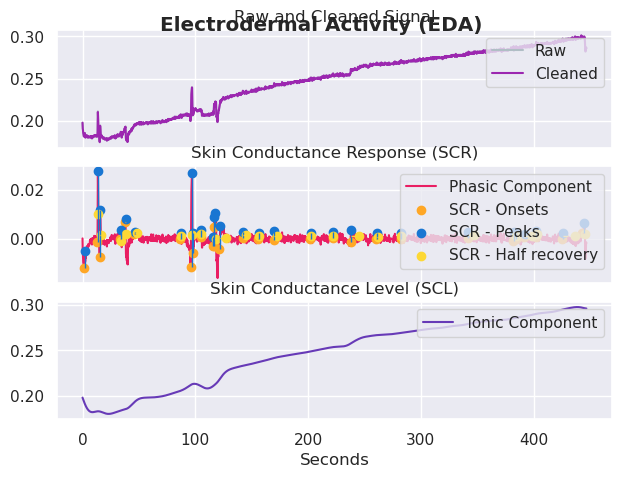

In [16]:
nk.eda_plot(signals.fillna(0), 8)

In [17]:
def get_EDA_features(path):
    df = pd.read_csv(f"{path}/EDA.csv", parse_dates=['time']).set_index('time').drop(columns=['Unnamed: 0'])
    # needs higher sampling rate, so we double it to 8 Hz
    df = df.resample('125ms').mean().interpolate(method='linear')
    sampling_rate_hz = 8
    eda_signal = df['EDA']
    signals, info = nk.eda_process(eda_signal.iloc[3:], sampling_rate=sampling_rate_hz)
    total_seconds = len(signals) / sampling_rate_hz
    features = [signals['SCR_Peaks'].sum() / total_seconds, #peaks per sec
                signals.loc[signals['SCR_Peaks'] == 1]['SCR_RiseTime'].mean(), # how long it took to rise on average when there was a peak
                signals.loc[signals['SCR_Peaks'] == 1]['SCR_Amplitude'].mean(),
                signals.loc[signals['SCR_Peaks'] == 1]['SCR_Height'].mean(),
                signals.loc[signals['SCR_Recovery'] == 1]['SCR_RecoveryTime'].mean(), # how long it took on average when there was a recovery
                signals['SCR_Onsets'].sum() / total_seconds, # onsets per sec (not neccessary the same as peaks... hmmm
                signals['EDA_Tonic'].max()-signals['EDA_Tonic'].min(), #about the general tendency
                signals['EDA_Tonic'].mean(),
                signals['EDA_Tonic'].std()]
    feature_names = ['SCR_peaks_Hz', 'SCR_RiseTime_mean', 'SCR_Amplitude_mean', 'SCR_height_mean', 'SCR_RecoveryTime_mean', 
                     'SCR_Onsets_Hz', 'Tonic_range', 'Tonic_mean', 'Tonic_std']
    return feature_names, features
    
get_EDA_features(path)

(['SCR_peaks_Hz',
  'SCR_RiseTime_mean',
  'SCR_Amplitude_mean',
  'SCR_height_mean',
  'SCR_RecoveryTime_mean',
  'SCR_Onsets_Hz',
  'Tonic_range',
  'Tonic_mean',
  'Tonic_std'],
 [0.06491326245103525,
  0.46551724137931033,
  0.006427697926095158,
  0.00526280918194219,
  1.53125,
  0.06491326245103525,
  0.11785564906562548,
  0.24741607552933564,
  0.03600928147828097])

In [18]:
eda_ds = []
for path in metadata['Path']:
    feature_names, features = get_EDA_features(path)
    eda_ds.append(features)
    
eda_ds = pd.DataFrame(eda_ds, columns = feature_names)

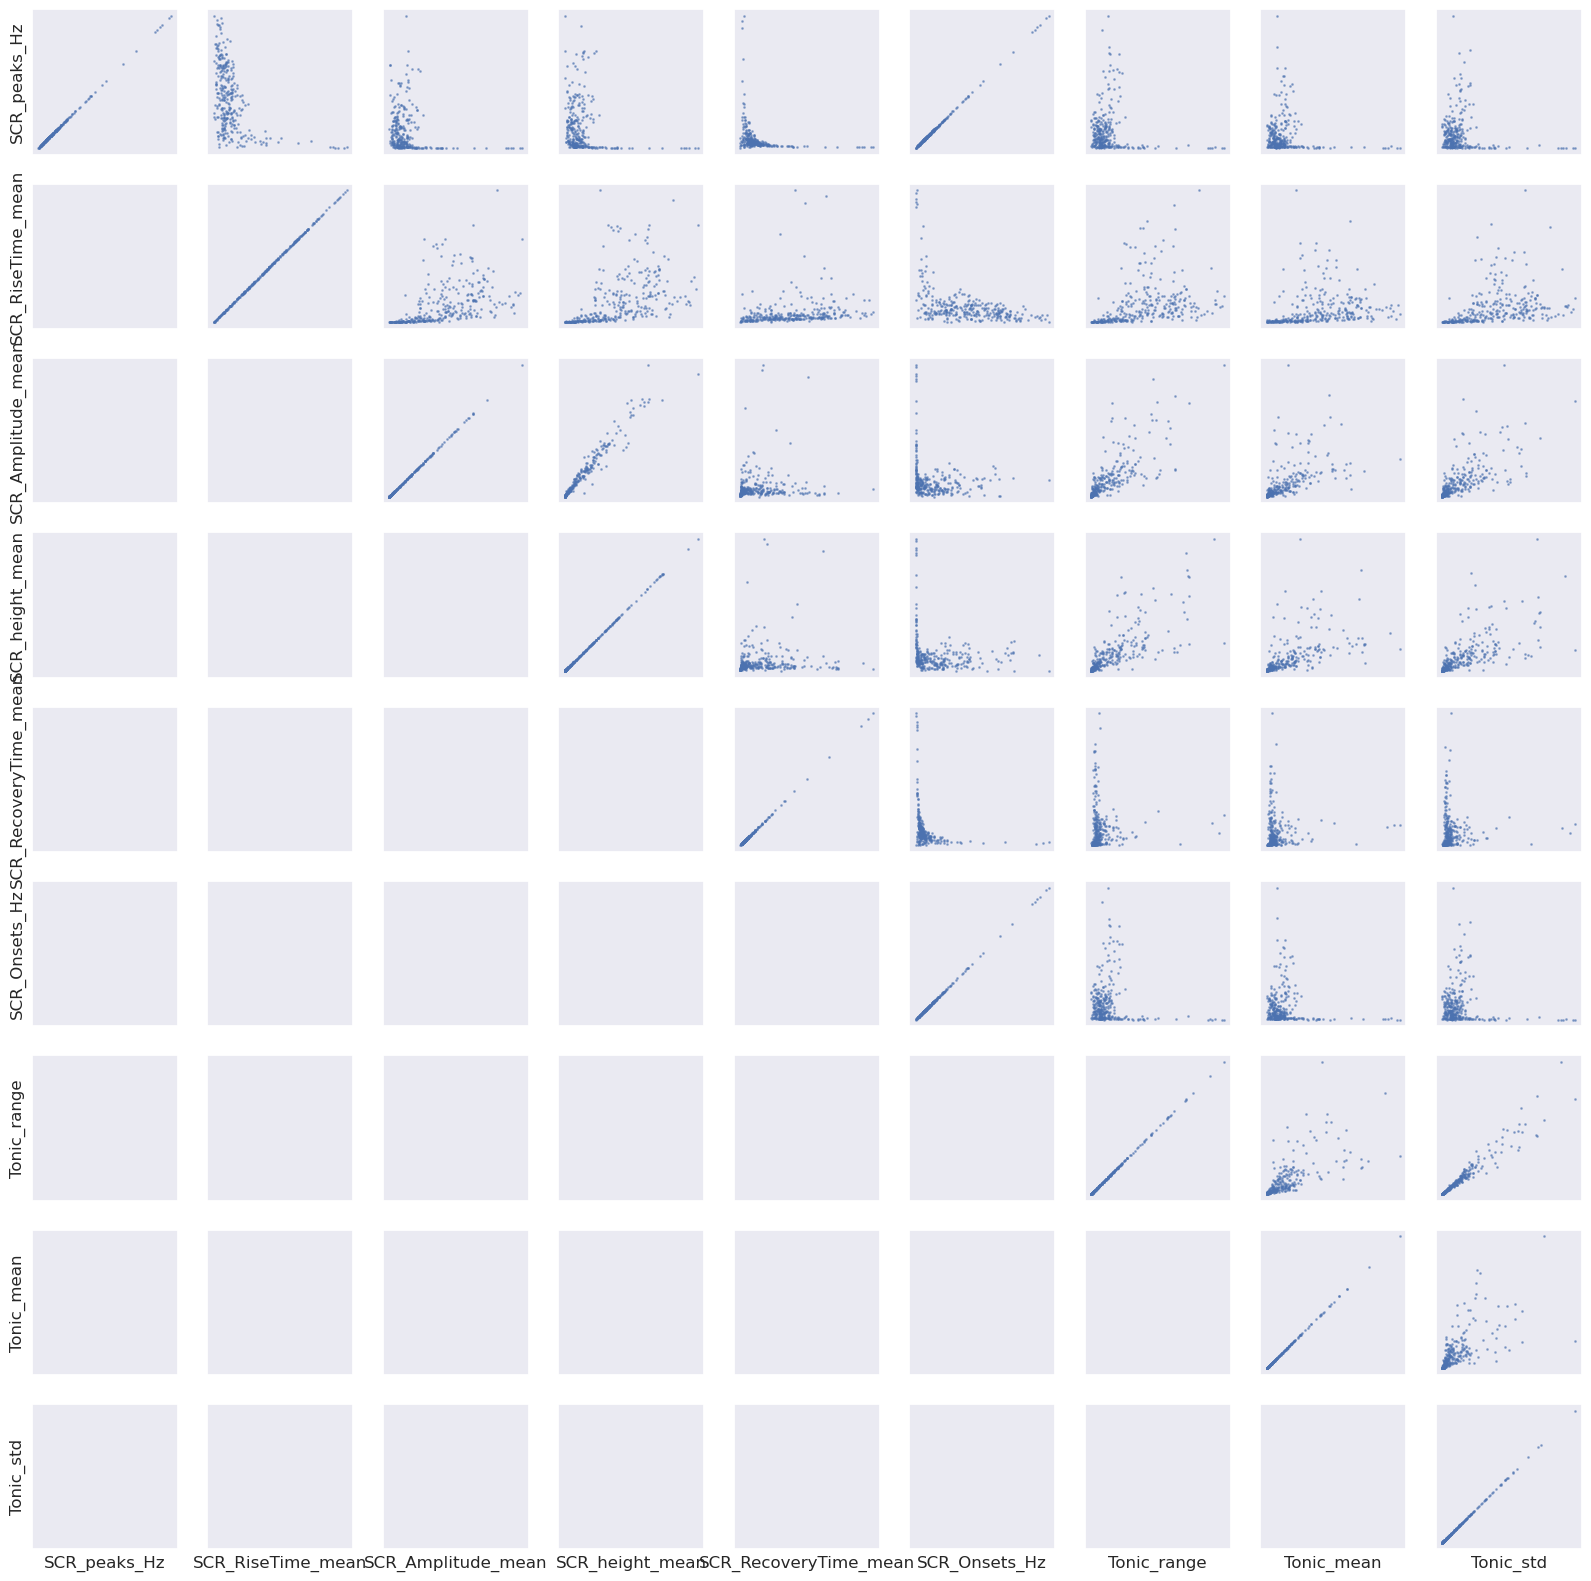

In [19]:
p = len(eda_ds.columns)
fig, axs = plt.subplots(p, p, figsize=(20, 20))
for i, f1 in enumerate(eda_ds.columns):
    for j, f2 in enumerate(eda_ds.columns):
        if i <= j:
            axs[i][j].scatter(eda_ds[f1], eda_ds[f2], s=1, alpha=0.5)
        axs[i][j].set_xticks([])
        axs[i][j].set_yticks([])
        
        if j == 0:
            axs[i][j].set_ylabel(f1)
        if i == p-1:
            axs[i][j].set_xlabel(f2)
plt.show()

cohort 1: 12/17  
cohort 2: 8/17  
cohort 3: 10/18  

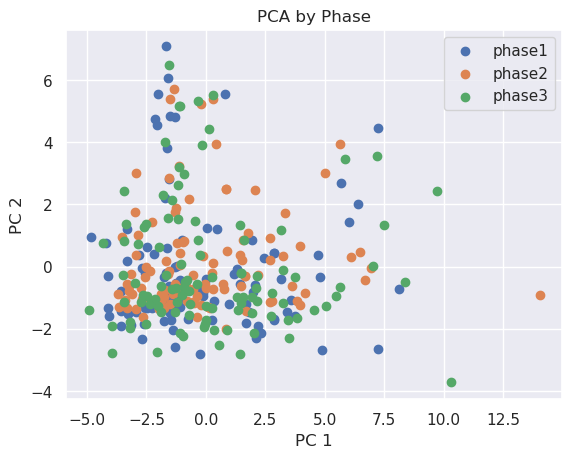

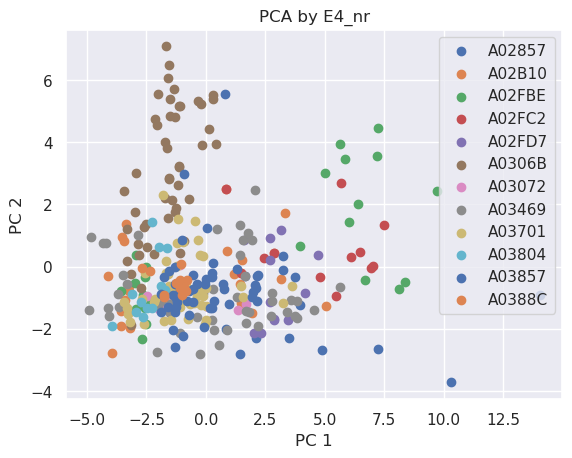

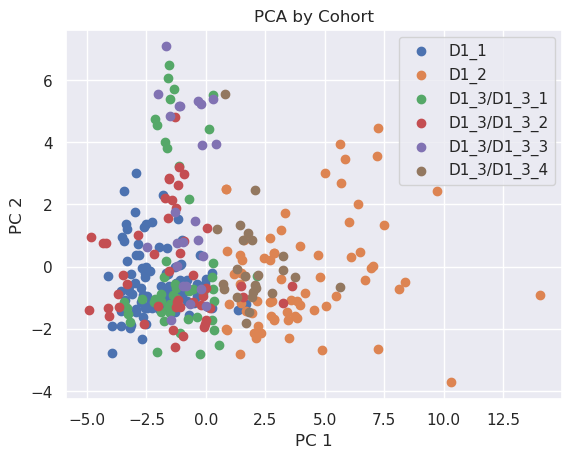

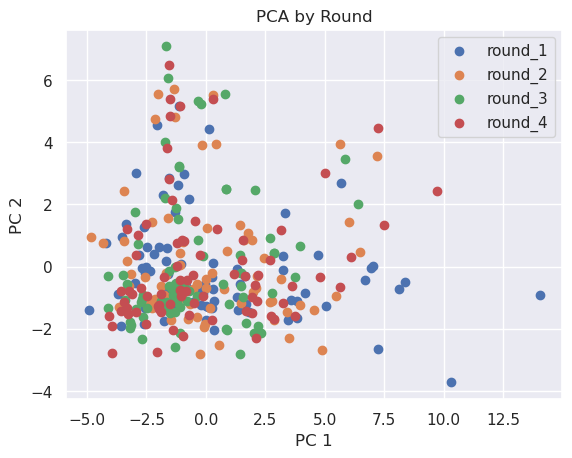

In [20]:
def pca_visualize(ds, by_column):
    meta = metadata.iloc[ds.index]
    X = StandardScaler().fit_transform(ds)
    pca = PCA(n_components=2)
    components = pca.fit_transform(X)
    plt.figure()
    for c in sorted(meta[by_column].unique()):
        idxs = meta[by_column] == c
        plt.scatter(components[idxs, 0], components[idxs, 1], label=c)
    plt.title(f"PCA by {by_column}")
    plt.xlabel("PC 1")
    plt.ylabel("PC 2")
    plt.legend()
    plt.show()
    
    
ds = pd.concat((eda_ds, basic_ds), axis=1)
pca_visualize(ds, "Phase") # unfortunatelly no distinct groups in phases (with these features)
pca_visualize(ds, "E4_nr") # distinct groups
pca_visualize(ds, "Cohort") # Cohort 2 stands out as it was summer (more sweathing)
pca_visualize(ds, "Round") # it's good that rounds are consistent, but maybe because phases are...


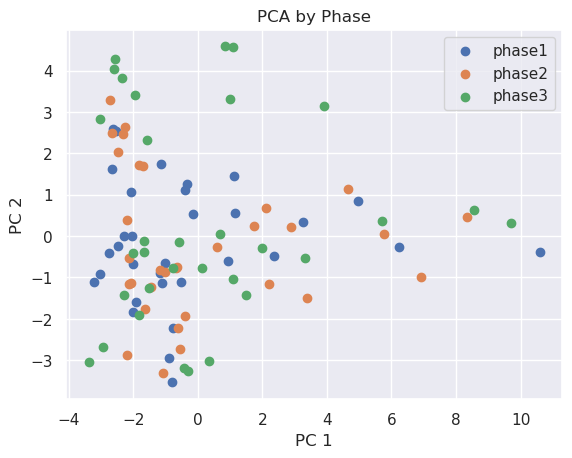

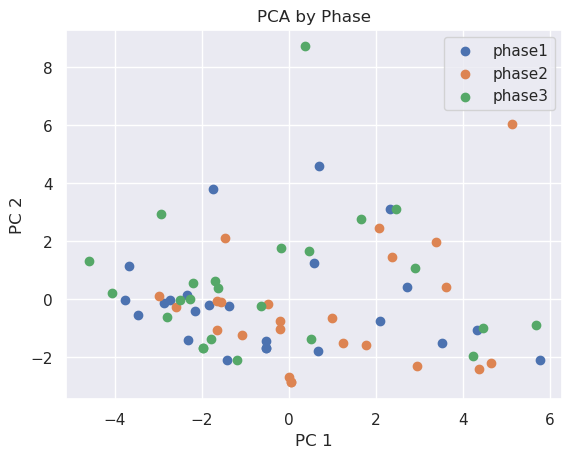

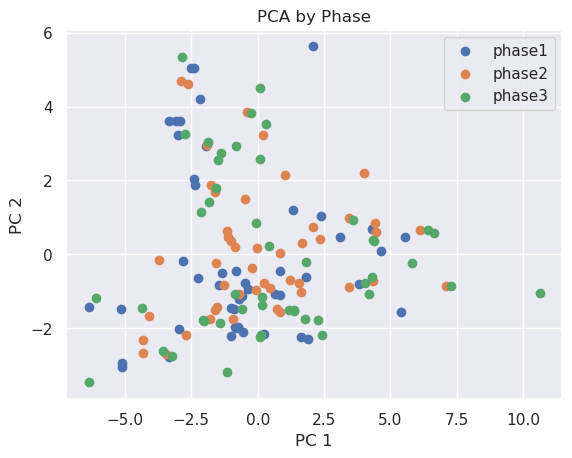

In [21]:
# let's filter on cohort - unfortunatelly nothing stands out
pca_visualize(ds.loc[metadata['Cohort'] == 'D1_1'], "Phase")
pca_visualize(ds.loc[metadata['Cohort'] == 'D1_2'], "Phase")
pca_visualize(ds.loc[metadata['Cohort'].str.startswith("D1_3")], "Phase")

# The others

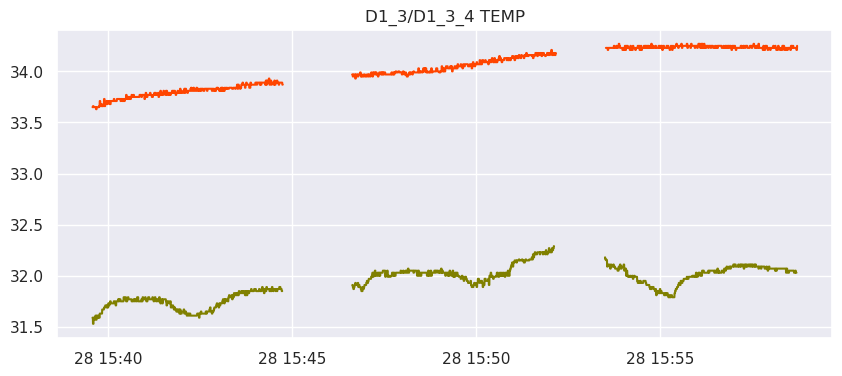

In [22]:
stat = 'TEMP'
plt.figure(figsize=(10, 4))
ls = ["dashed", "solid", "dotted"]
colors = ["orangered", "olive", "turquoise", "pink", "grey", "purple", "darkblue", "forestgreen"]
cohort = 'D1_3/D1_3_4'
plt.title(f"{cohort} {stat}")
for i in range(3):
    trial_ids = metadata.loc[metadata['Cohort'] == cohort]["Trial"].unique()
    for j, trial_id in enumerate(trial_ids):
        df = pd.read_csv(f"dataset/{cohort}/{trial_id}/round_1/phase{i+1}/{stat}.csv", parse_dates=['time']).drop(columns=['Unnamed: 0'])
        plt.plot(df['time'], df[stat], c=colors[j])

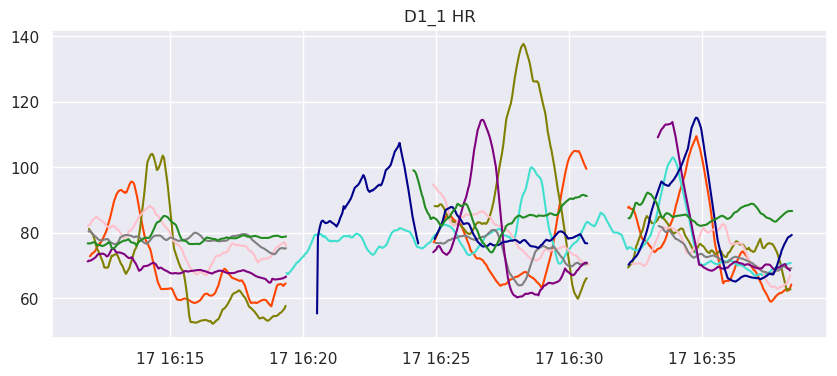

In [23]:
stat = 'HR'
plt.figure(figsize=(10, 4))
ls = ["dashed", "solid", "dotted"]
colors = ["orangered", "olive", "turquoise", "pink", "grey", "purple", "darkblue", "forestgreen"]
cohort = 'D1_1'
plt.title(f"{cohort} {stat}")
for i in range(3):
    trial_ids = metadata.loc[metadata['Cohort'] == cohort]["Trial"].unique()
    for j, trial_id in enumerate(trial_ids):
        df = pd.read_csv(f"dataset/{cohort}/{trial_id}/round_1/phase{i+1}/{stat}.csv", parse_dates=['time']).drop(columns=['Unnamed: 0'])
        plt.plot(df['time'], df[stat], c=colors[j])

In [24]:
# what is happening with "D1_2/ID_5/round_1/phase_1/HR.csv
metadata.loc[metadata['Path'].str.startswith('dataset/D1_2/ID_5/round_1')][['participant_ID', 'upset', 'hostile', 'alert',
       'ashamed', 'inspired', 'nervous', 'determined', 'attentive', 'afraid',
       'active', 'frustrated', 'difficulty']] #hmmm nothing stands out

,participant_ID,upset,hostile,alert,ashamed,inspired,nervous,determined,attentive,afraid,active,frustrated,difficulty
